# Data Handling

In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [37]:
stock_des = pd.read_csv("Data\stock_descriptions.csv", index_col=0)
restuarnt= stock_des[(stock_des['Industry'] == "RETAIL-EATING PLACES") | (stock_des['Industry'] == "RETAIL-EATING & DRINKING PLACES")]
restuarnt_list = restuarnt.index.unique().to_list()

In [38]:
price = pd.read_csv("Data/all_stock_and_etfs.csv", index_col=0)
for res in restuarnt_list:
    output_df = price[price.Ticker_Symbol == res]
    output_df.index = pd.to_datetime(output_df.index)
    output_df.to_csv(f"Restaurant_data/{res}_daily.csv")
    output_df.resample('MS').first()
    output_df.to_csv(f"Restaurant_data/{res}_monthly.csv")

In [39]:
commodities = pd.read_csv("Data/all_commodities.csv", index_col=0)
commodities = commodities.dropna()
commodities_list = commodities.Commodity.unique().tolist()
commodities = commodities[::-1]
for commodity in commodities_list:
    output_df = commodities[commodities.Commodity==commodity]
    output_df.index = pd.to_datetime(output_df.index)
    new_name = commodity + "_value"
    output_df = output_df['Value'].astype(float)
    output_df = output_df.rename(new_name)
    output_df = output_df.groupby(level=0).sum()
    output_df.to_csv(f"Commodities&Meat_data/{commodity}.csv")

In [40]:
Meat = pd.read_csv("Data/Meat_Stats_Meat_Production.csv", index_col=0)
Meat_list = Meat["Animal"].unique().tolist()
Meat = Meat[::-1]
for animal in Meat_list:
    output_df = Meat[Meat.Animal==animal]
    output_df.index = pd.to_datetime(output_df.index)
    output_df = output_df["Production"].str.replace(',', '').astype(float)
    new_name = animal + "_Production"
    output_df = output_df.rename(new_name)
    output_df = output_df.groupby(level=0).sum()
    output_df.to_csv(f"Commodities&Meat_data/{animal}.csv")

C:\Users\anson\AppData\Local\Temp\ipykernel_32268\2260590510.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  output_df.index = pd.to_datetime(output_df.index)
C:\Users\anson\AppData\Local\Temp\ipykernel_32268\2260590510.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  output_df.index = pd.to_datetime(output_df.index)
C:\Users\anson\AppData\Local\Temp\ipykernel_32268\2260590510.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  output_df.index = pd.to_datetime(output_df.index)
C:\Users\anson\AppData\Local\Temp\ipykernel_32268\2260590510.py:6: UserWarning: Could not i

In [41]:
raw_data_df = pd.DataFrame()
tmp_df = pd.read_csv("Commodities&Meat_data\Beef.csv", index_col=0)
tmp_df = tmp_df.groupby(level=0).sum()
raw_data_df.index = tmp_df.index
for animal in Meat_list:
    tmp_df = pd.read_csv(f"Commodities&Meat_data\{animal}.csv", index_col=0)
    tmp_df = tmp_df.groupby(level=0).sum()
    raw_data_df = pd.concat([raw_data_df,tmp_df], axis=1)

In [42]:
for commodity in commodities_list:
    if (commodity != 'Corn'):
        tmp_df = pd.read_csv(f"Commodities&Meat_data\{commodity}.csv", index_col=0)
        tmp_df = tmp_df.groupby(level=0).sum()
        raw_data_df = pd.concat([raw_data_df,tmp_df], axis=1)

In [43]:
raw_data_df.to_csv("Commodities&Meat_data/raw.csv")

# Features Engineering

In [44]:
raw_data_df = pd.read_csv("Commodities&Meat_data/raw.csv", index_col=0)
pct_dfs = []
for column in raw_data_df.columns:
    temp = raw_data_df[column].astype(float)
    pct_df = temp.pct_change(1).to_frame(f"{column}_1m")
    pct_df[f"{column}_3m"] = temp.pct_change(3)
    pct_df[f"{column}_6m"] = temp.pct_change(6)
    pct_dfs.append(pct_df)

processed_data = pd.concat(pct_dfs, axis=1)

C:\Users\anson\AppData\Local\Temp\ipykernel_32268\1274862100.py:4: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pct_df = temp.pct_change(1).to_frame(f"{column}_1m")
C:\Users\anson\AppData\Local\Temp\ipykernel_32268\1274862100.py:5: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pct_df[f"{column}_3m"] = temp.pct_change(3)
C:\Users\anson\AppData\Local\Temp\ipykernel_32268\1274862100.py:6: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_metho

In [45]:
processed_data
processed_data.to_csv("Intermediate_data/meat_pct_change.csv")

In [47]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
import xgboost as xgb
import matplotlib.pyplot as plt

from evidently.report import Report
from evidently.metric_preset import DataDriftPreset, TargetDriftPreset, DataQualityPreset, ClassificationPreset

# ML Model

In [66]:
def run_test(COMPANY, ub, lb):

    dataset = pd.read_csv("Intermediate_data\meat_pct_change.csv", index_col=0)
    dataset.index = pd.to_datetime(dataset.index)
    price = pd.read_csv(f"Restaurant_data/{COMPANY}_daily.csv", index_col=0)
    price = price[::-1]
    price.index = pd.to_datetime(price.index)
    price = price.resample('MS').first()
    price['return'] = (1+price['Close'].pct_change())
    price['Signal'] = np.where(price['return']>ub, 2, np.where(price['return']<lb, 0, 1))

    signal = price['Signal']

    dataset = pd.concat([dataset,signal], axis=1)
    dataset = dataset.replace([np.inf, -np.inf], np.nan).dropna()

    split_index = int(len(dataset) * 0.8)
    train_df = dataset[:split_index]
    test_df = dataset[split_index:]

    X_train = train_df.drop('Signal', axis=1)
    y_train = train_df['Signal']
    X_test = test_df.drop('Signal', axis=1)
    y_test = test_df['Signal']


    model = xgb.XGBClassifier(objective='multi:softmax')

    param_grid = {
        'learning_rate': [0.1, 0.01, 0.001],
        'max_depth': [3, 5],
        'n_estimators': [100, 200, 300],
        'gamma':[0.01, 0.1],
        'reg_lambda':[0.01, 0.1, 0.2],
    }

    grid_search = GridSearchCV(estimator=model, 
                           param_grid=param_grid, 
                           cv=3)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    print("Accuracy:", accuracy_score(best_model.predict(X_test),y_test))
    xgb.plot_importance(best_model)
    reference = dataset[:split_index]
    current = dataset[split_index:]
    reference.rename(columns={'Signal':'target'},inplace=True)
    current.rename(columns={'Signal':'target'},inplace=True)
    reference['prediction'] = best_model.predict(X_train)
    current['prediction'] = best_model.predict(X_test)

    classification_report = Report(metrics=[
        ClassificationPreset()
    ])
    classification_report.run(current_data=current, reference_data=reference)
    classification_report.save_html(f'ML_Reports/{COMPANY}.html')

    return

# Run tests

Accuracy: 0.5227272727272727


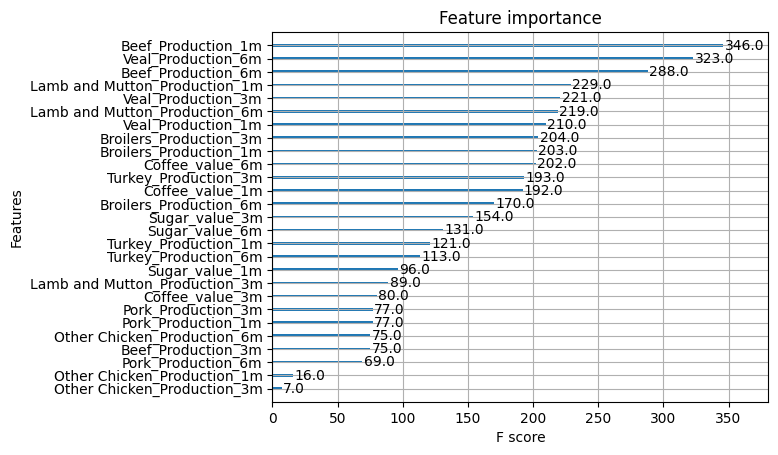

In [67]:
COMPANY = "CMG"
ub = 0.03
lb = -0.01

run_test(COMPANY, 1+ub, 1+lb)

Accuracy: 0.41818181818181815


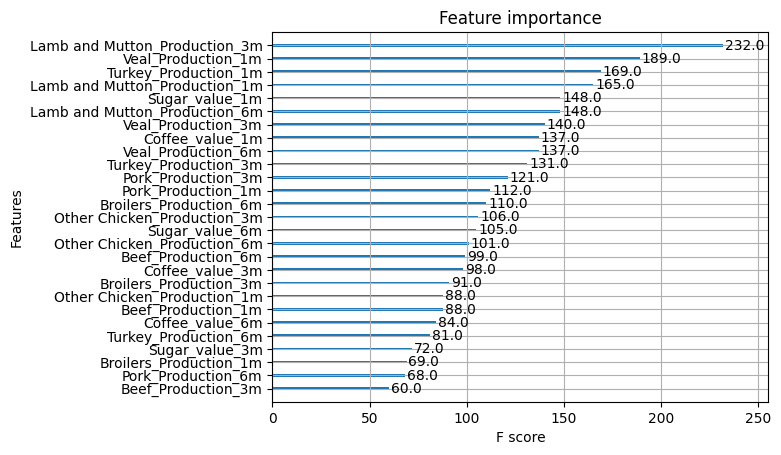

In [68]:
COMPANY = "DRI"
ub = 0.03
lb = -0.01

run_test(COMPANY, 1+ub, 1+lb)

Accuracy: 0.36363636363636365


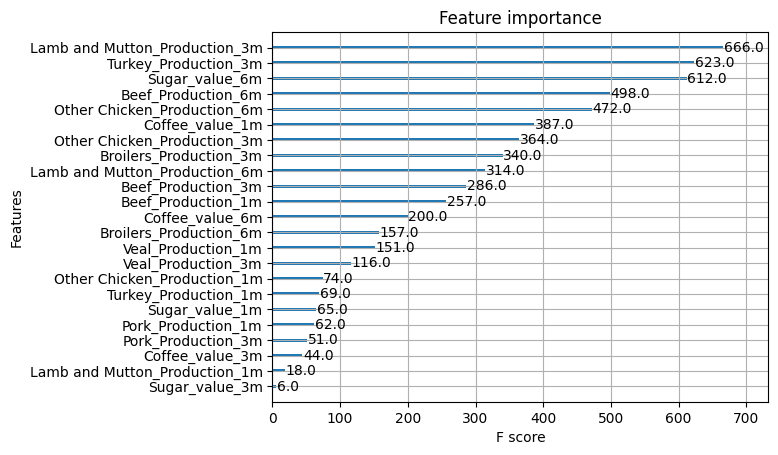

In [69]:
COMPANY = "MCD"
ub = 0.03
lb = -0.01

run_test(COMPANY, 1+ub, 1+lb)

Accuracy: 0.2727272727272727


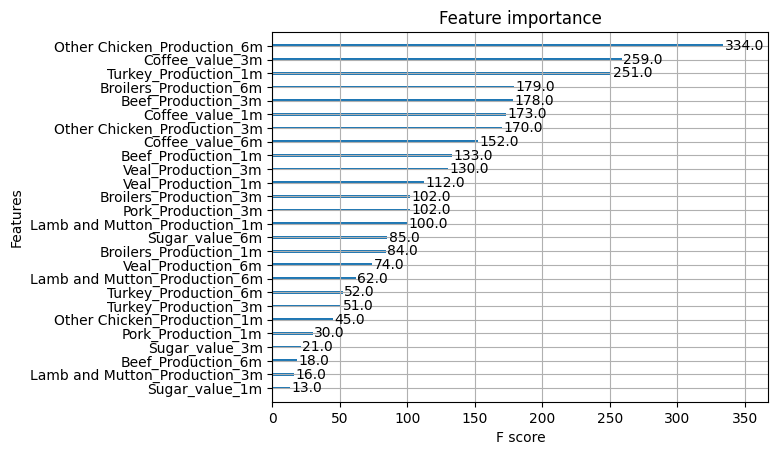

In [70]:
COMPANY = "QSR"
ub = 0.03
lb = -0.01

run_test(COMPANY, 1+ub, 1+lb)

Accuracy: 0.41818181818181815


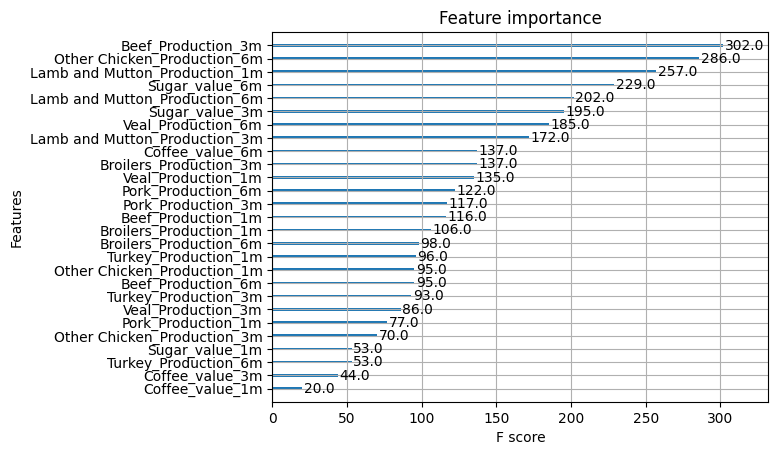

In [71]:
COMPANY = "SBUX"
ub = 0.03
lb = -0.01

run_test(COMPANY, 1+ub, 1+lb)

Accuracy: 0.2545454545454545


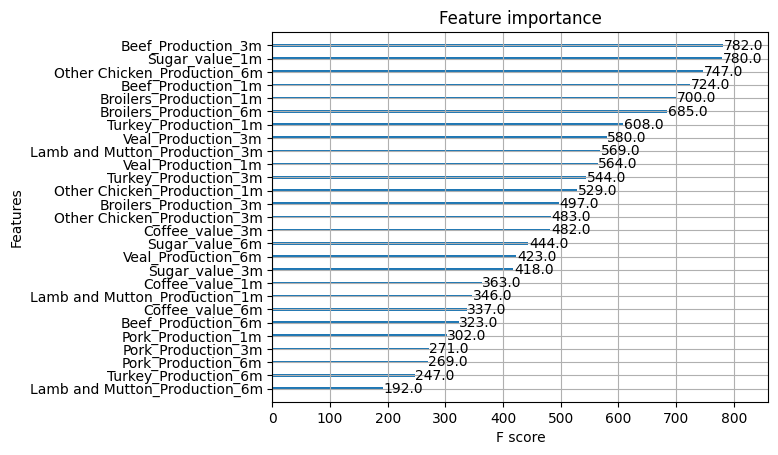

In [72]:
COMPANY = "WEN"
ub = 0.03
lb = -0.01

run_test(COMPANY, 1+ub, 1+lb)

Accuracy: 0.36363636363636365


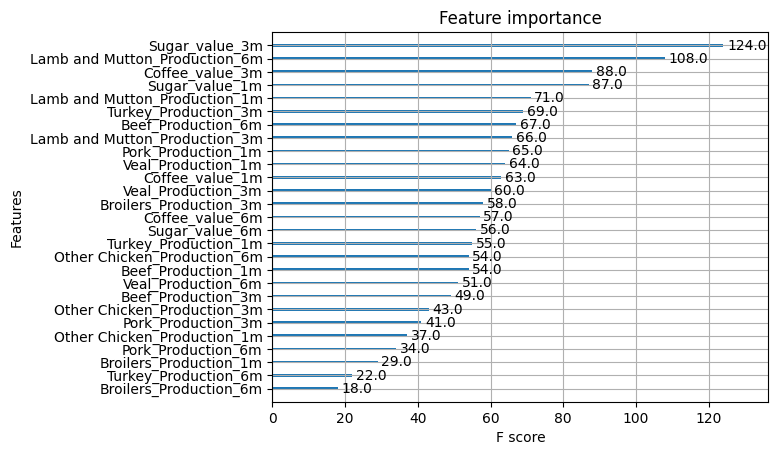

In [73]:
COMPANY = "YUM"
ub = 0.03
lb = -0.01

run_test(COMPANY, 1+ub, 1+lb)